Data from yahoo finance

In [92]:

import yfinance as yf
from datetime import datetime

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [93]:
dataset = yf.download('TSLA', start='2022-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'),
                      progress=False,
                      period="ytd")
dataset = dataset.reset_index()
dataset['Date'] = pd.to_datetime(dataset['Date'])   
dataset.index = range(len(dataset))
dataset.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,382.583344,400.356659,378.679993,399.926666,399.926666,103931400
1,2022-01-04,396.516663,402.666656,374.350006,383.196655,383.196655,100248300
2,2022-01-05,382.216675,390.113342,360.336670,362.706665,362.706665,80119800
3,2022-01-06,359.000000,362.666656,340.166656,354.899994,354.899994,90336600
4,2022-01-07,360.123322,360.309998,336.666656,342.320007,342.320007,84164700


In [94]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       628 non-null    datetime64[ns]
 1   Open       628 non-null    float64       
 2   High       628 non-null    float64       
 3   Low        628 non-null    float64       
 4   Close      628 non-null    float64       
 5   Adj Close  628 non-null    float64       
 6   Volume     628 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 34.5 KB


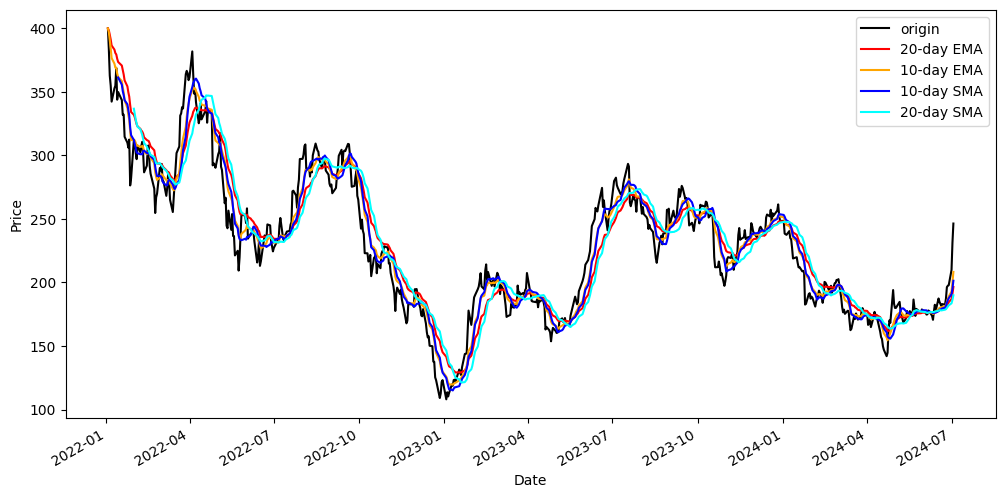

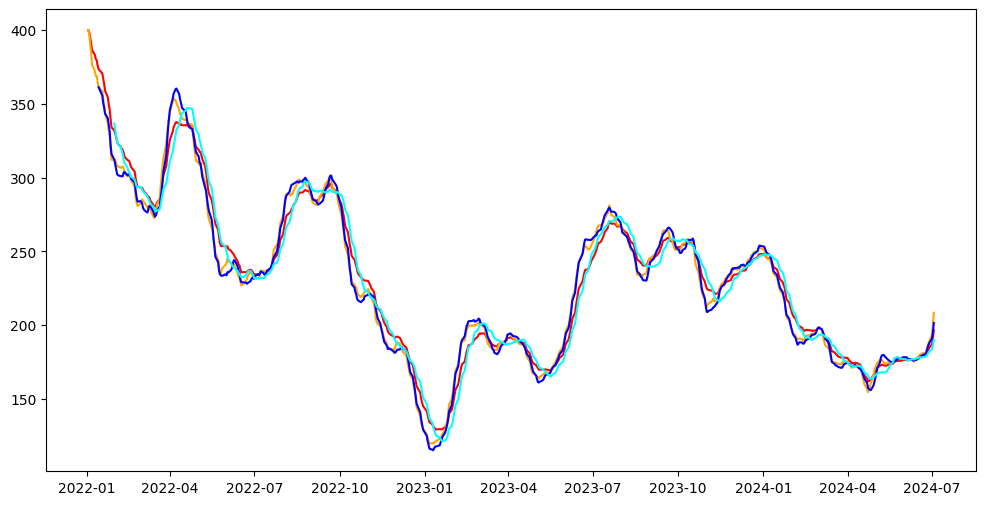

In [95]:
sma_20 = dataset['Close'].rolling(window=20).mean()
sma_10 = dataset['Close'].rolling(window=10).mean()
ema_20 = dataset['Close'].ewm(span=20, adjust=False).mean()
ema_10 = dataset['Close'].ewm(span=10, adjust=False).mean()

def show():

    plt.plot(dataset['Date'], ema_20, label='20-day EMA', color='red')
    plt.plot(dataset['Date'], ema_10, label='10-day EMA', color='orange')   
    plt.plot(dataset['Date'], sma_10, label='10-day SMA', color='blue')
    plt.plot(dataset['Date'], sma_20, label='20-day SMA', color='cyan')


plt.figure(figsize=(12, 6))
plt.plot(dataset['Date'], dataset['Close'], label='origin', color='black')
show()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

plt.figure(figsize=(12, 6))
show()  
plt.show()

Remove Missing Value 
Remove Outliers techniques like z-score or IQR 

Number of outliers detected by Z-score method: 1
mean: 229.33282363794413
lower_bound: 61.66750907897949
upper_bound: 387.4474925994873
std_dev_close: 54.87205353372634


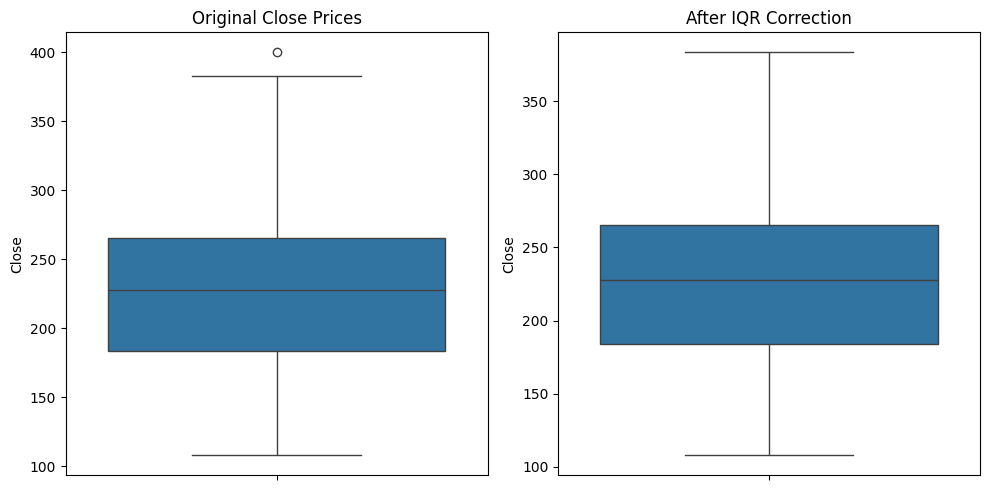

In [96]:
import seaborn as sns
from scipy.stats import zscore
import statistics

Q1 = dataset['Close'].quantile(0.25)
Q3 = dataset['Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = dataset[(dataset['Close'] < lower_bound)
                       | (dataset['Close'] > upper_bound)]
df_iqr_corrected = dataset[(dataset['Close'] >= lower_bound) & (
    dataset['Close'] <= upper_bound)]

# Using Standard Deviation to remove outliers
threshold = 3
mean_close = dataset['Close'].mean()
std_dev_close = dataset['Close'].std()
outliers_std = dataset[(dataset['Close'] < mean_close - threshold * std_dev_close)
                       | (dataset['Close'] > mean_close + threshold * std_dev_close)]
df_std_corrected = dataset[(dataset['Close'] >= mean_close - threshold * std_dev_close)
                           & (dataset['Close'] <= mean_close + threshold * std_dev_close)]

# Using Z-score to remove outliers
mean_close = statistics.mean(dataset['Close'])
std_dev_close = statistics.stdev(dataset['Close'])
z_scores = [(price - mean_close) / std_dev_close for price in dataset['Close']]
df_z_corrected = dataset[[(abs(z) < threshold) for z in z_scores]]

# Print the number of outliers detected by the Z-score method
outliers_z = dataset[[(abs(z) >= threshold) for z in z_scores]]
print("Number of outliers detected by Z-score method:", len(outliers_z))

# Printing values
print("mean:", mean_close)
print("lower_bound:", lower_bound)
print("upper_bound:", upper_bound)
print("std_dev_close:", std_dev_close)

# Plotting to visualize
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.boxplot(y=dataset['Close'], ax=axes[0]).set_title('Original Close Prices')
sns.boxplot(y=df_iqr_corrected['Close'], ax=axes[1]
            ).set_title('After IQR Correction')
plt.tight_layout()
plt.show()

Exponential Smoothing
Kalman Filter (assumes constant level with Gaussian noise)

refference: https://medium.com/@row3no6/how-to-handle-noise-in-your-time-series-data-5979ca2ceb5f

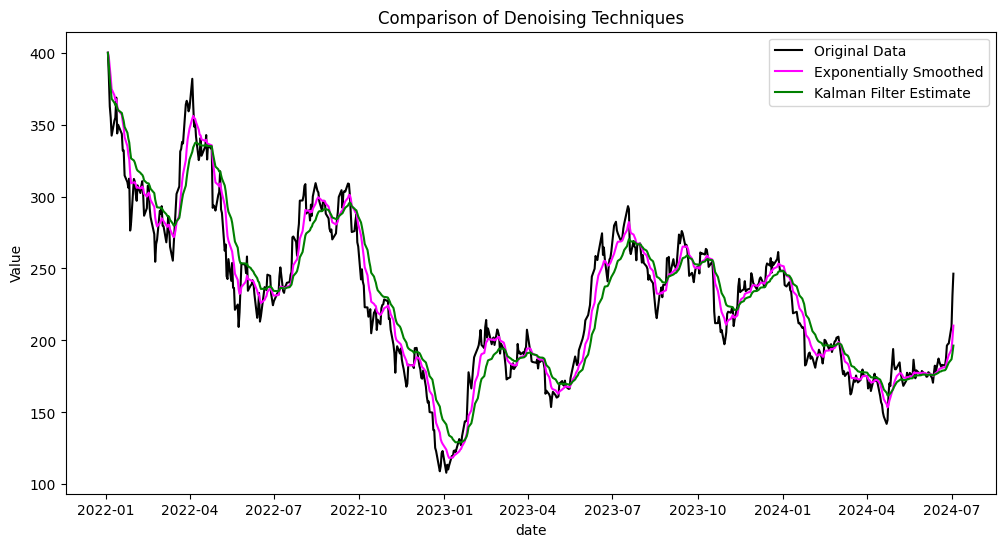

In [97]:
# Exponential Smoothing
alpha = 0.2  # Smoothing factor (adjust for desired responsiveness)
smoothed_data = np.zeros_like(dataset['Close'])  # Initialize smoothed data array
smoothed_data[0] = dataset['Close'][0]  
for i in range(1, len(dataset['Close'])):
    smoothed_data[i] = alpha * dataset['Close'][i] + (1 - alpha) * smoothed_data[i-1]

# Kalman Filter (assumes constant level with Gaussian noise)
Q = 0.01
R = 1  # Measurement noise covariance (adjust for noise level)
P = 1  # Initial state covariance
xhat = np.zeros_like(dataset['Close'])  # Kalman filter state estimate (level)
xhat[0] = dataset['Close'][0]
for i in range(1, len(dataset['Close'])):
    # Predict
    xhat_pred = xhat[i-1]
    Phat_pred = P + Q

    # Update
    K = Phat_pred / (Phat_pred + R)
    xhat[i] = xhat_pred + K * (dataset['Close'][i] - xhat_pred)
    P = (1 - K) * Phat_pred

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(dataset['Date'], dataset['Close'],
         label='Original Data', color='black')
plt.plot(dataset['Date'], smoothed_data,
         label='Exponentially Smoothed', color='magenta')
plt.plot(dataset['Date'], xhat,
         label='Kalman Filter Estimate', color='green')
plt.xlabel('date')
plt.ylabel('Value')
plt.legend()
plt.title('Comparison of Denoising Techniques')
plt.show()

Compare all component

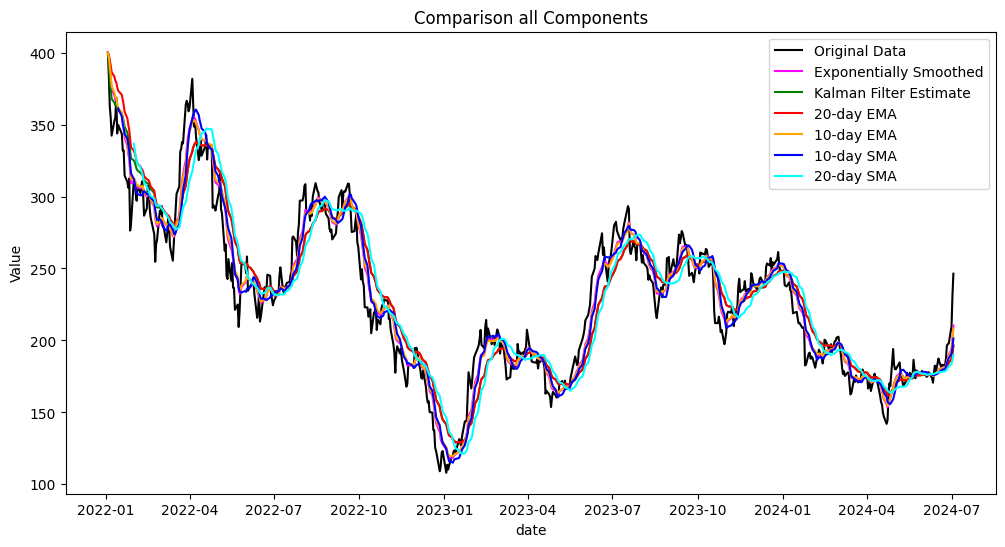

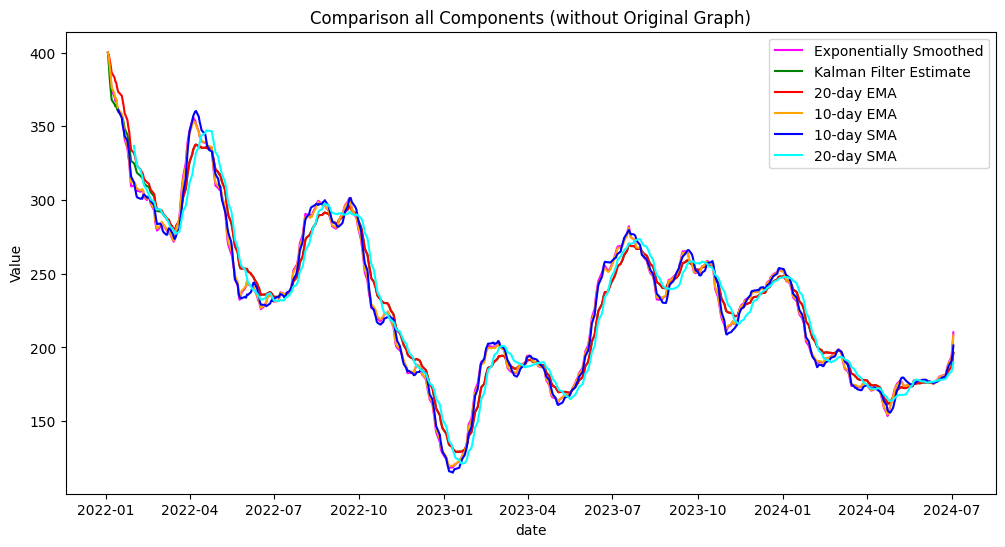

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(dataset['Date'], dataset['Close'],
         label='Original Data', color='black')
plt.plot(dataset['Date'], smoothed_data,
         label='Exponentially Smoothed', color='magenta')
plt.plot(dataset['Date'], xhat,
         label='Kalman Filter Estimate', color='green')
show()
plt.xlabel('date')
plt.ylabel('Value')
plt.legend()
plt.title('Comparison all Components')
plt.show()
# Plot comparison without original data
plt.figure(figsize=(12, 6))
plt.plot(dataset['Date'], smoothed_data,
         label='Exponentially Smoothed', color='magenta')
plt.plot(dataset['Date'], xhat,
         label='Kalman Filter Estimate', color='green')
show()
plt.xlabel('date')
plt.ylabel('Value')
plt.legend()
plt.title('Comparison all Components (without Original Graph)')
plt.show()